## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)  

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
l1_ratio = 0.0001
Batch_Size = 256
MOMENTUM = 0.95
drop_ratio = 0.25


model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2

In [7]:
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=Batch_Size,
          validation_data=(x_test, y_test),
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 266us/step - loss: 6.0838 - acc: 0.2820 - val_loss: 5.7456 - val_acc: 0.3613
Epoch 2/50
50000/50000 [==============================] - 11s 215us/step - loss: 5.6716 - acc: 0.3737 - val_loss: 5.5721 - val_acc: 0.3983
Epoch 3/50
50000/50000 [==============================] - 11s 213us/step - loss: 5.5113 - acc: 0.4063 - val_loss: 5.4333 - val_acc: 0.4186- acc: 0.40 - ETA: 0s - loss: 5.5150 - ac
Epoch 4/50
50000/50000 [==============================] - 11s 211us/step - loss: 5.3879 - acc: 0.4286 - val_loss: 5.3394 - val_acc: 0.4262
Epoch 5/50
50000/50000 [==============================] - 11s 211us/step - loss: 5.2825 - acc: 0.4416 - val_loss: 5.2319 - val_acc: 0.4450
Epoch 6/50
50000/50000 [==============================] - 11s 211us/step - loss: 5.1965 - acc: 0.4488 - val_loss: 5.1728 - val_acc: 0.4399
Epoch 7/50
50000/50000 [===

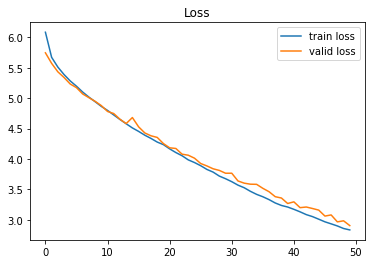

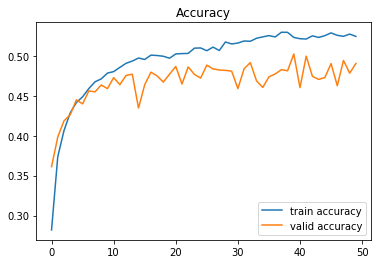

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()